## Robots Temporal Analysis P2

1486
6331
7815
Number of tokens in 3000 URLs: 20625432937 | 12.13% of c4


/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/web_analysis/../web_analysis/robots_util.py:263: UserWarning: Discarding nonzero nanoseconds in conversion.
  target_end_date = target_period.end_time.to_pydatetime().date()


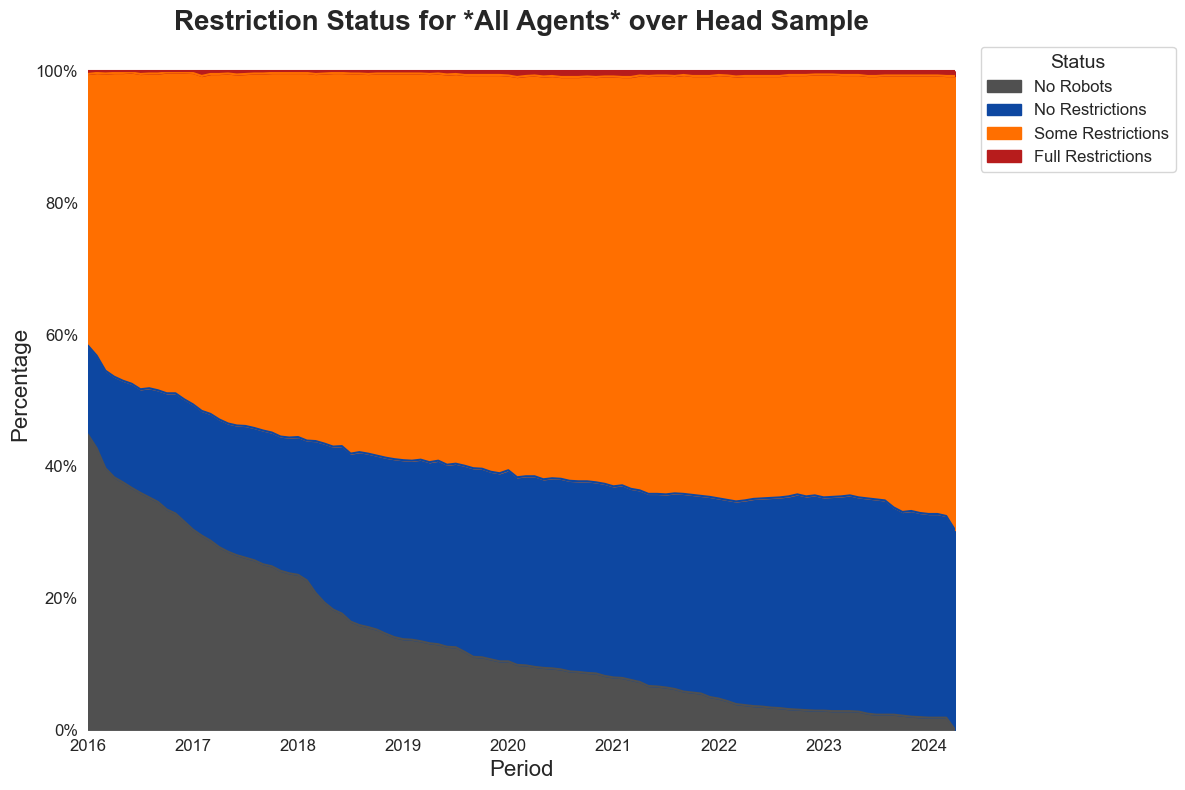

<Figure size 640x480 with 0 Axes>

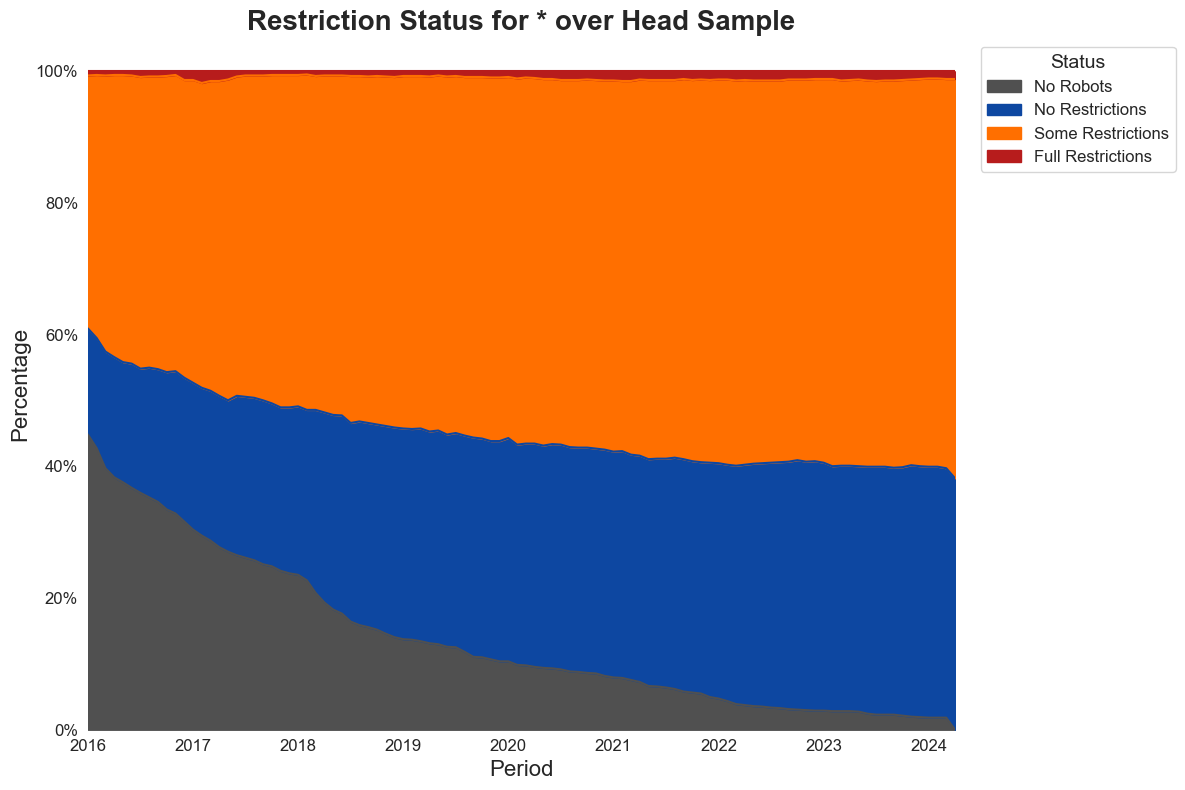

<Figure size 640x480 with 0 Axes>

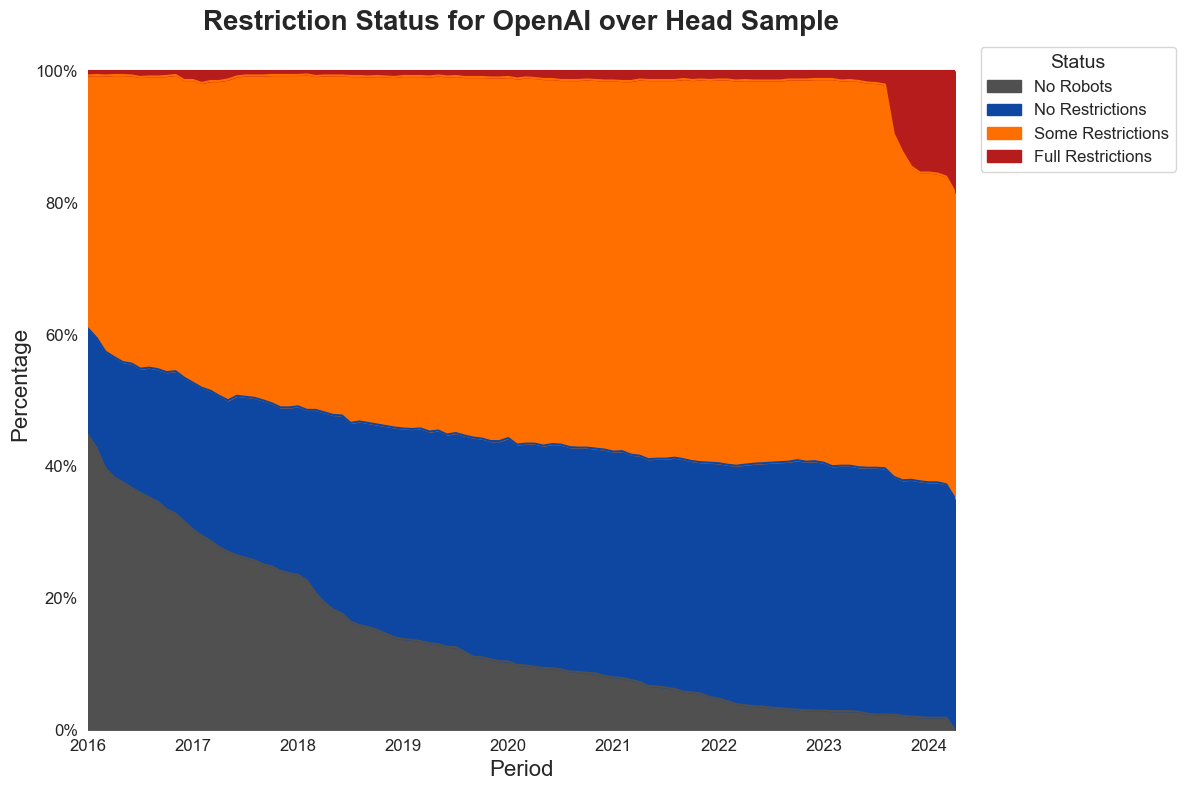

<Figure size 640x480 with 0 Axes>

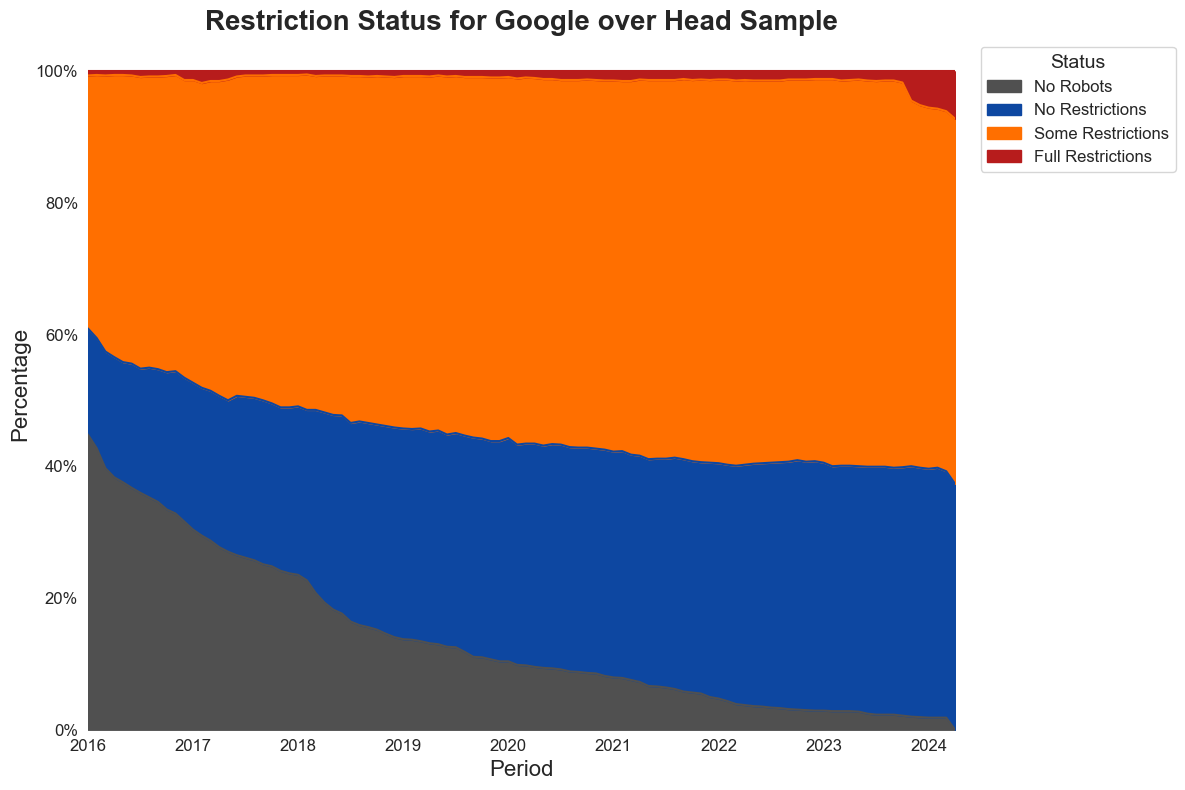

<Figure size 640x480 with 0 Axes>

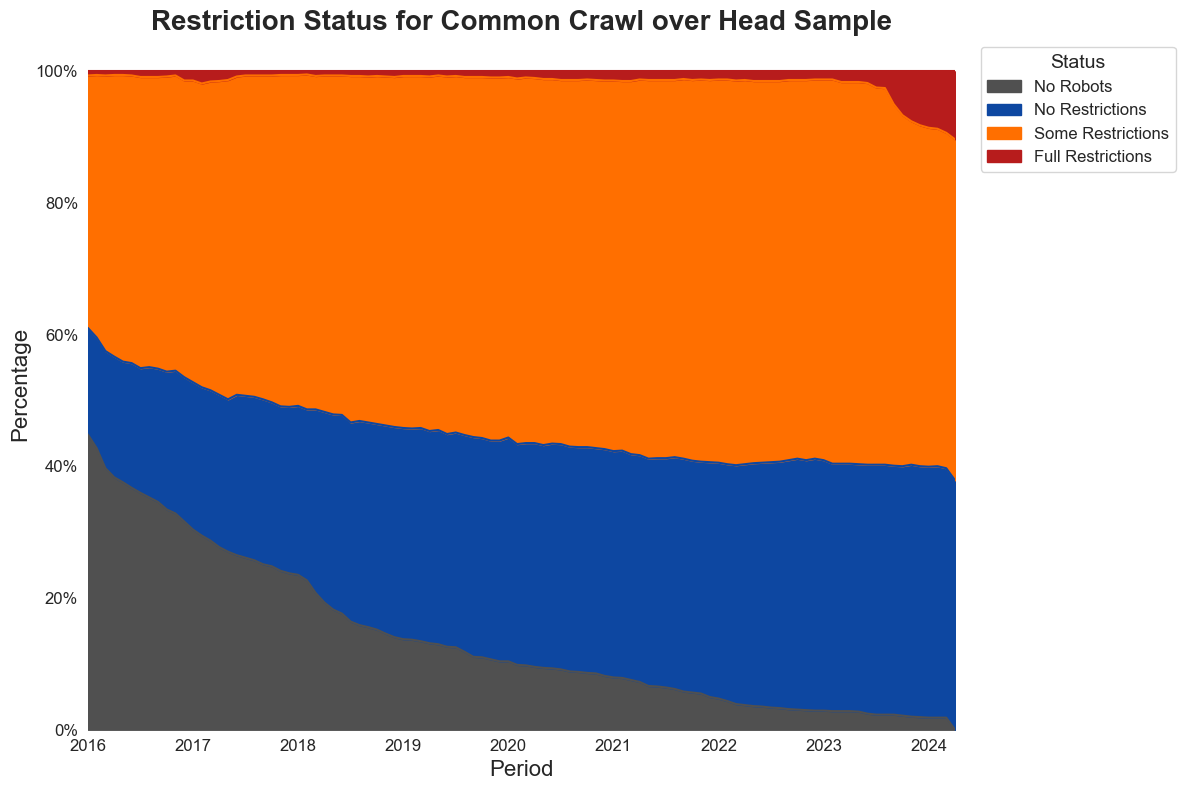

<Figure size 640x480 with 0 Axes>

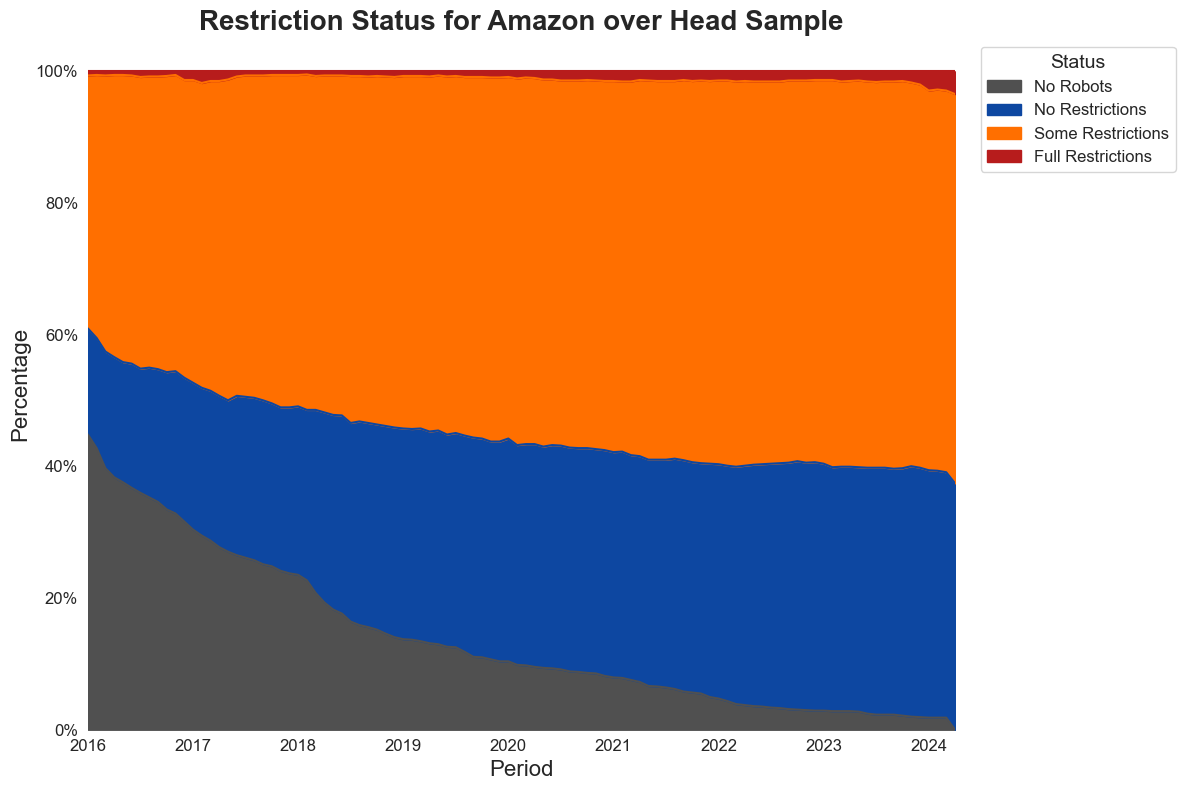

<Figure size 640x480 with 0 Axes>

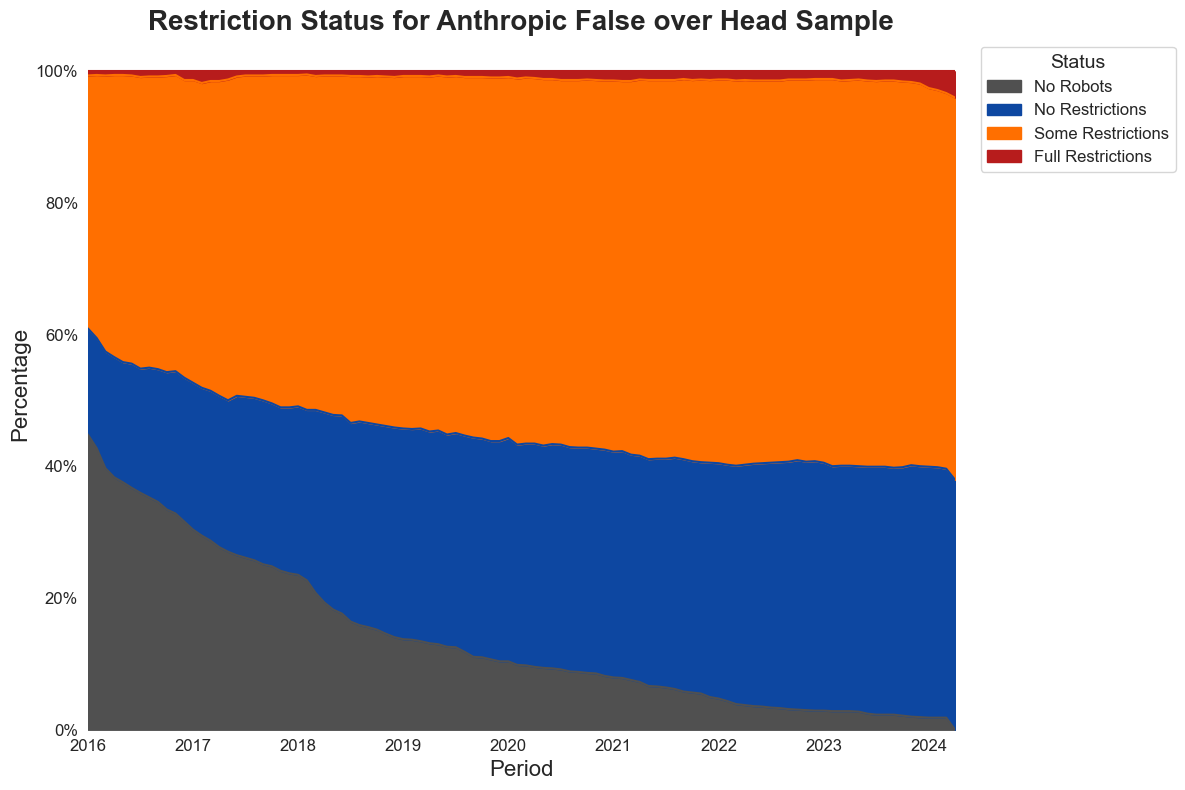

<Figure size 640x480 with 0 Axes>

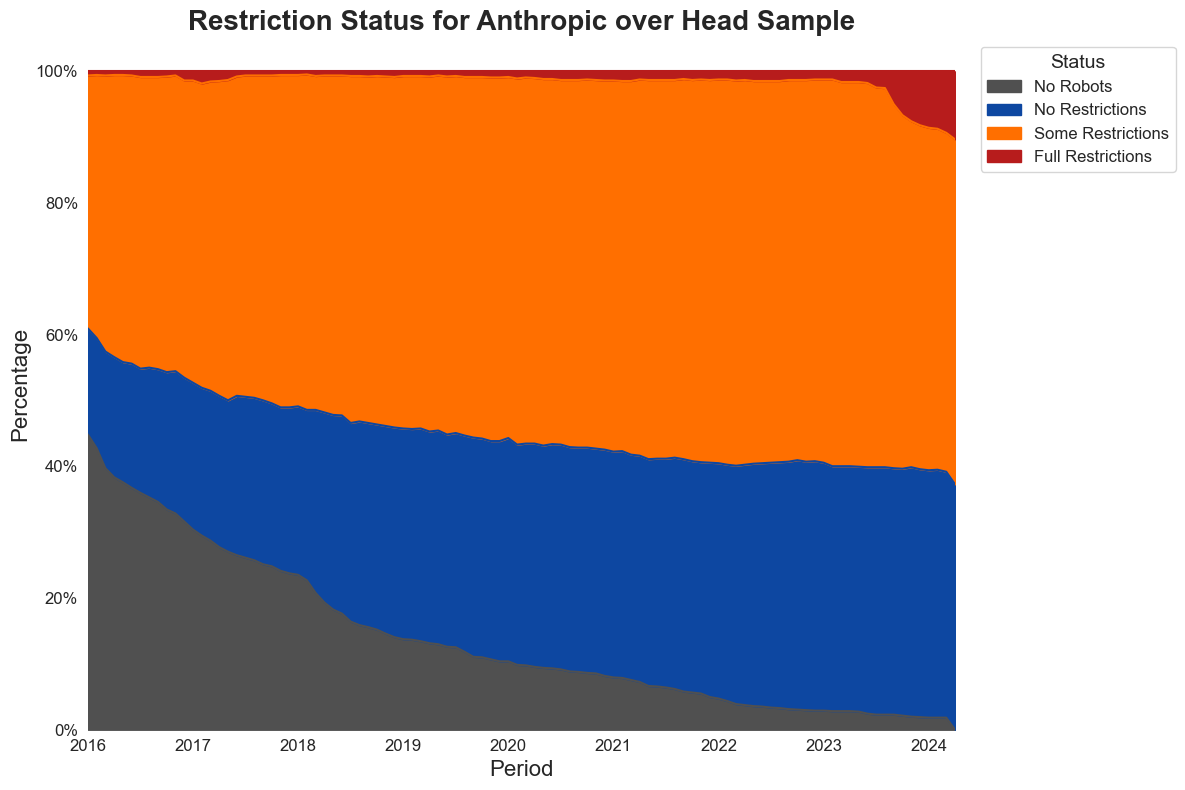

<Figure size 640x480 with 0 Axes>

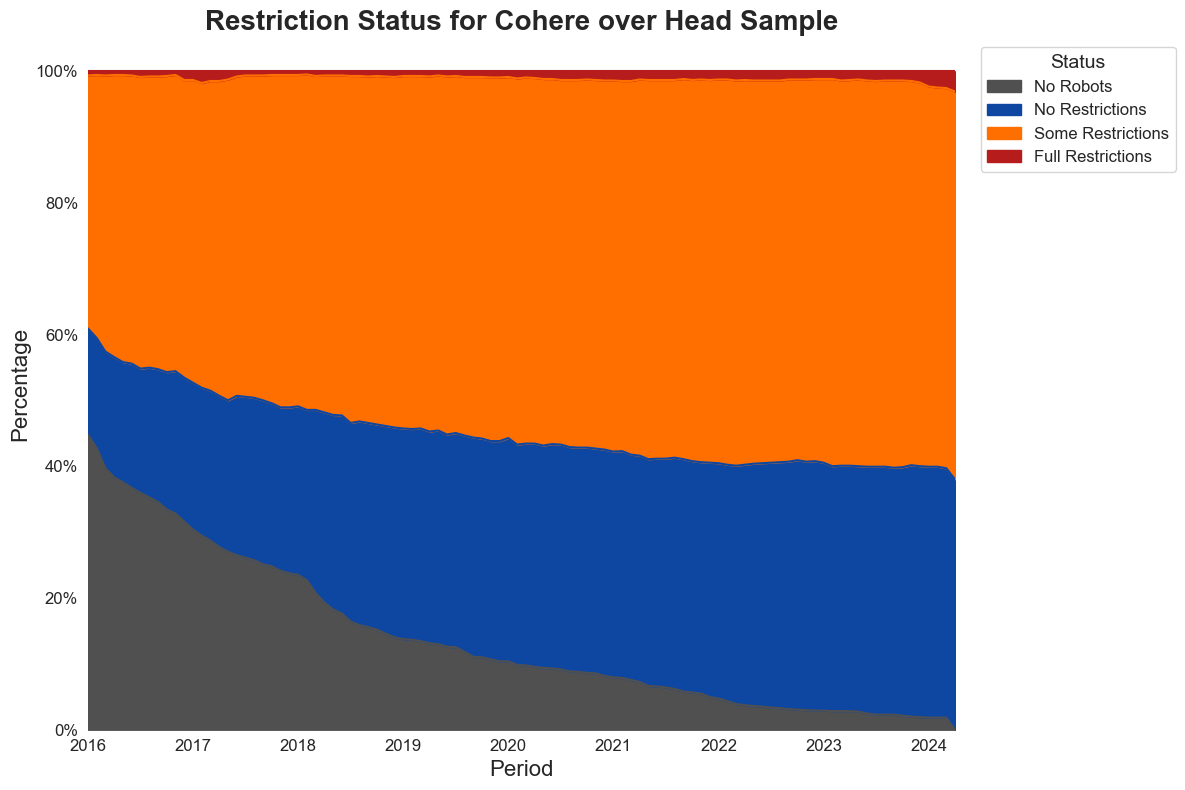

<Figure size 640x480 with 0 Axes>

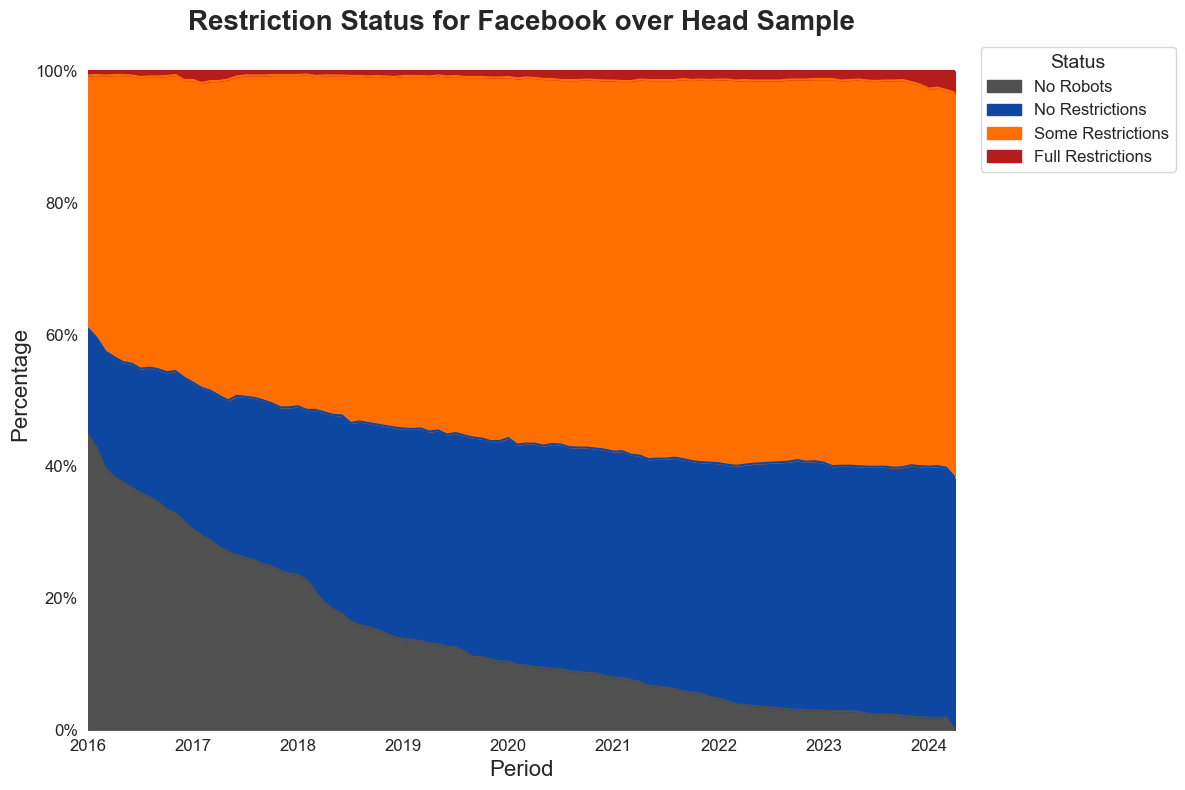

<Figure size 640x480 with 0 Axes>

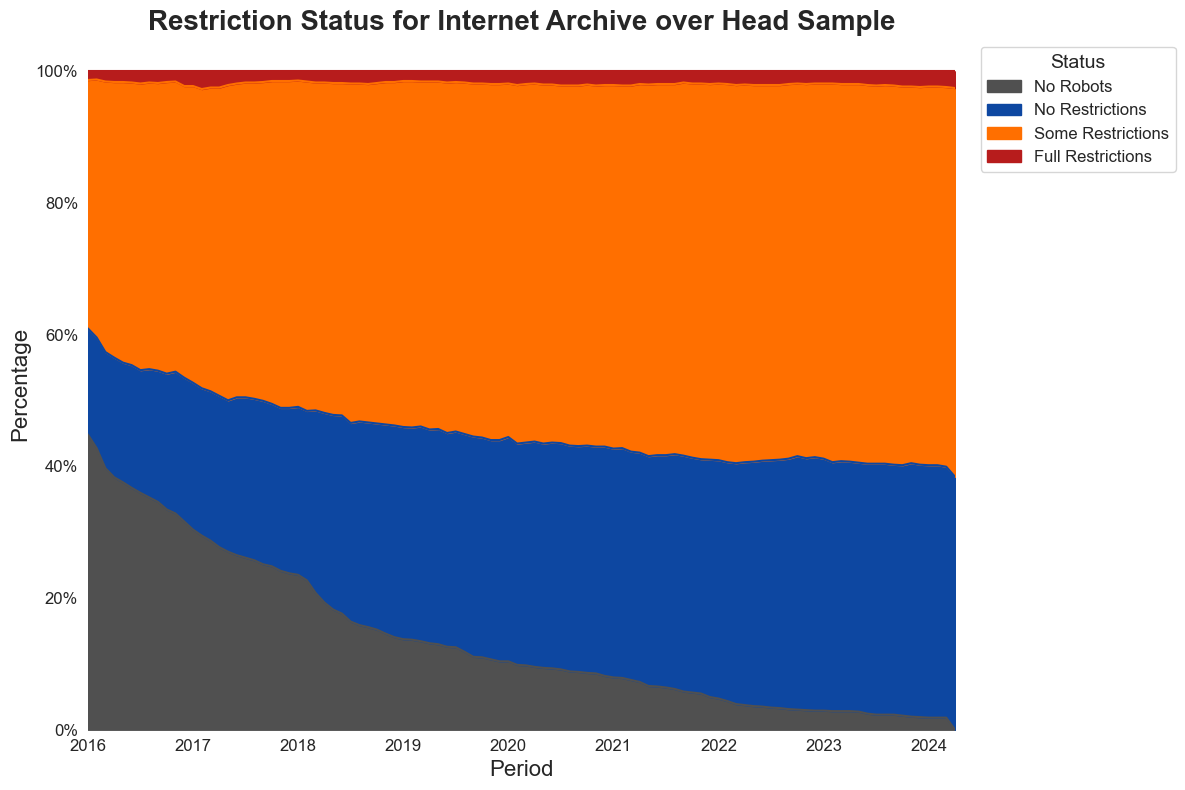

<Figure size 640x480 with 0 Axes>

In [1]:
import json
import os
import re
import sys
import copy
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from pmdarima import auto_arima
from scipy.stats import boxcox
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from urllib.parse import urlparse

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io
from web_analysis import robots_util


%load_ext autoreload
%autoreload 2
url_token_lookup = robots_util.URLTokenLookup('/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/analysis/pretrain_data/relevant_url_token_counts.csv') # 'c4', 'rf', 'dolma'
c4_url_to_counts = url_token_lookup.get_url_to_token_map("c4")
# URL -> Date -> Robots.txt raw text
head_robots = io.read_json("/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/temporal_robots_head.json")
random_10k_robots = io.read_json("/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/temporal_robots_rand_10k.json")
joined_robots = copy.deepcopy(head_robots)
joined_robots.update(random_10k_robots)
print(len(head_robots))
print(len(random_10k_robots))
print(len(joined_robots))

def sanitize_url(url: str) -> str:
    """
    Sanitizes URL to be used as a folder name.
    """
    parsed_url = urlparse(url)
    sanitized_netloc = parsed_url.netloc.replace(".", "_")
    sanitized_path = "_".join(
        filter(None, re.split(r"\/+", parsed_url.path.strip("/")))
    )
    sanitized_url = f"{sanitized_netloc}_{sanitized_path}"
    return sanitized_url.replace(".", "_")


def get_website_start_dates(snapshot_dir):
    start_dates = {}
    for sanitized_url in os.listdir(snapshot_dir):
        url_dir = os.path.join(snapshot_dir, sanitized_url)
        if os.path.isdir(url_dir):
            snapshots = [f for f in os.listdir(url_dir) if f.endswith('.html')]
            if snapshots:
                earliest_snapshot = min(snapshots)
                start_date_str = earliest_snapshot.split('.')[0]  # Extract the date string from the file name
                start_date = pd.to_datetime(start_date_str, format='%Y%m%d%H%M%S')  # Parse the date string using the correct format
                start_dates[sanitized_url] = start_date
    return start_dates

snapshot_dir = '/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/web_analysis/wayback_extraction/snapshots'  # Replace with the actual path to the snapshots directory
sanitized_start_dates = get_website_start_dates(snapshot_dir)

# Map the sanitized URLs back to the original URLs
website_start_dates = {url: sanitized_start_dates.get(sanitize_url(url), pd.to_datetime('1970-01-01')) for url in joined_robots}

# run compute_url_date_agent_status for random and head.
# filter URLs for random vs head before 
# compute size vs robots restritiveness (All Agents, OpenAI, Google) stats
# time, size, robots
agent_groups_to_track = robots_util.get_bot_groups()
agents_to_track = robots_util.get_bots()
# {URL --> Date --> Agent --> Status}
url_robots_summary = robots_util.compute_url_date_agent_status(
    data=joined_robots, 
    # relevant_agents=agents_to_track)
    relevant_agents=[v for vs in agent_groups_to_track.values() for v in vs])
# top N sample: TODO: Top 1k vs top 800 token info.
top_c4_urls = url_token_lookup.top_k_urls("c4", 3000)
url_robots_summary_head = {k: url_robots_summary[k] for k in top_c4_urls if k in top_c4_urls}
url_robots_summary_rand = {k: url_robots_summary[k] for k, _ in random_10k_robots.items()}


# {Period --> Agent --> Status --> set(URLs)}
robots_filled_status_head_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_head, 
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
    website_start_dates=website_start_dates,  # Pass the website start dates
)
robots_filled_status_rand_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_rand, 
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
    website_start_dates=website_start_dates,  # Pass the website start dates
)


# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_head_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_head_summary,
    url_to_counts=c4_url_to_counts,
)
# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_rand_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_rand_summary,
    url_to_counts=c4_url_to_counts,
)


def plot_robots_time_map(df, agent_type, val_key):
    # Filter the DataFrame for the relevant agent
    filtered_df = df[df['agent'] == agent_type]
    
    # Group by 'period' and 'status', and sum up the 'count'
    grouped_df = filtered_df.groupby(['period', 'status'])[val_key].sum().unstack(fill_value=0)
    
    # Optional: Reorder the columns as desired
    ordered_statuses = ['no_robots', 'none', 'some', 'all']
    grouped_df = grouped_df[ordered_statuses]
    
    # Calculate the total counts for each period
    total_counts = grouped_df.sum(axis=1)
    
    # Calculate the percentage of each status per period
    percent_df = grouped_df.div(total_counts, axis=0) * 100
    
    # Specify colors for each stack
    colors = ['#505050', '#0D47A1', '#FF6F00', '#B71C1C']
    
    # Optional: Rename columns for custom labels in the legend
    percent_df.columns = ['No Robots', 'No Restrictions', 'Some Restrictions', 'Full Restrictions']
    
    # Set up the plot style
    sns.set_style("white")
    
    # Create a figure and axis with a larger size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plotting the stacked area chart with no transparency
    percent_df.plot(kind='area', stacked=True, color=colors, ax=ax)
    
    # Set the title and labels with customized font sizes
    ax.set_title(f"Restriction Status for {agent_type} over Head Sample", fontsize=20, fontweight='bold')
    ax.set_xlabel('Period', fontsize=16)
    ax.set_ylabel('Percentage', fontsize=16)
    
    # Adjust the legend
    ax.legend(title='Status', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Remove all spines (axis lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Adjust the tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add percentage labels to the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}%"))
    
    # Adjust the spacing and margins
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    
    # Display the plot
    plt.show()
    plt.clf()


# Loop through the agent groups and plot the data
for group in agent_groups_to_track:
    plot_robots_time_map(robots_temporal_head_summary, group, val_key="count")

#### Annual results (monthly above)

/Users/ariel-raive/Desktop/Data-Provenance-Collection/src/web_analysis/../web_analysis/robots_util.py:263: UserWarning: Discarding nonzero nanoseconds in conversion.
  target_end_date = target_period.end_time.to_pydatetime().date()


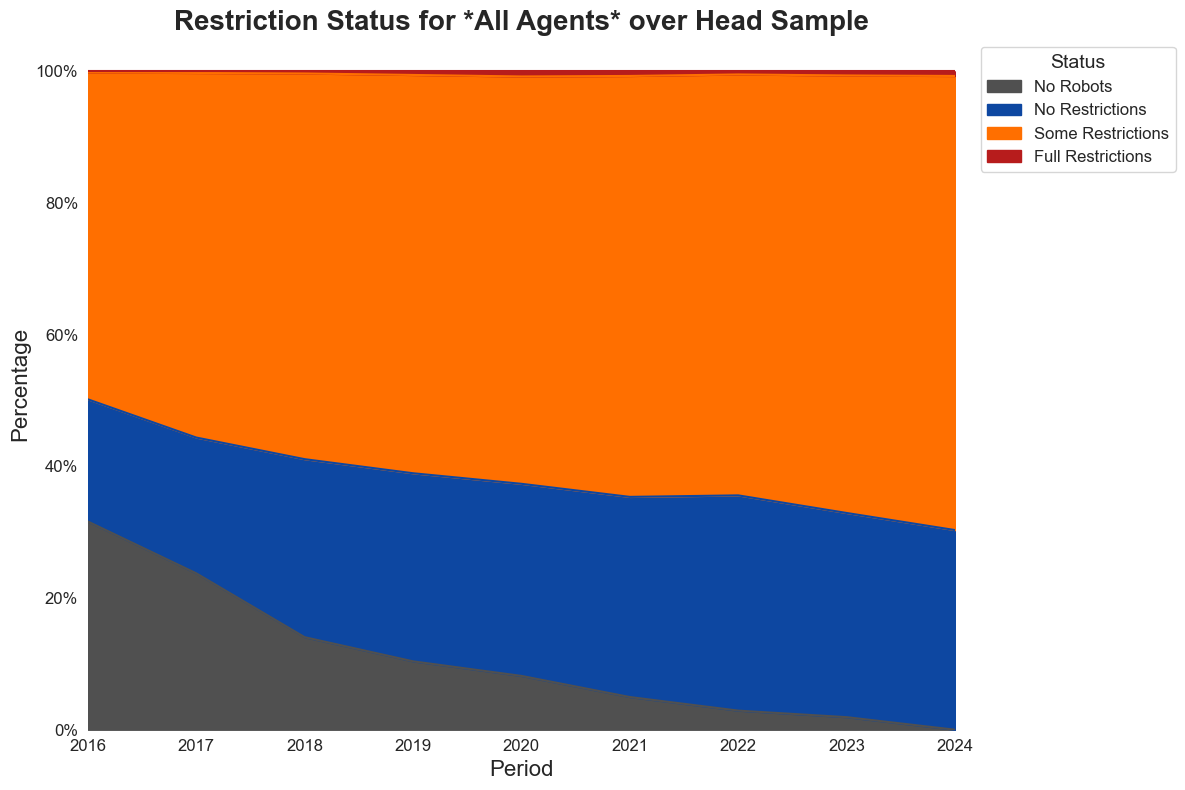

<Figure size 640x480 with 0 Axes>

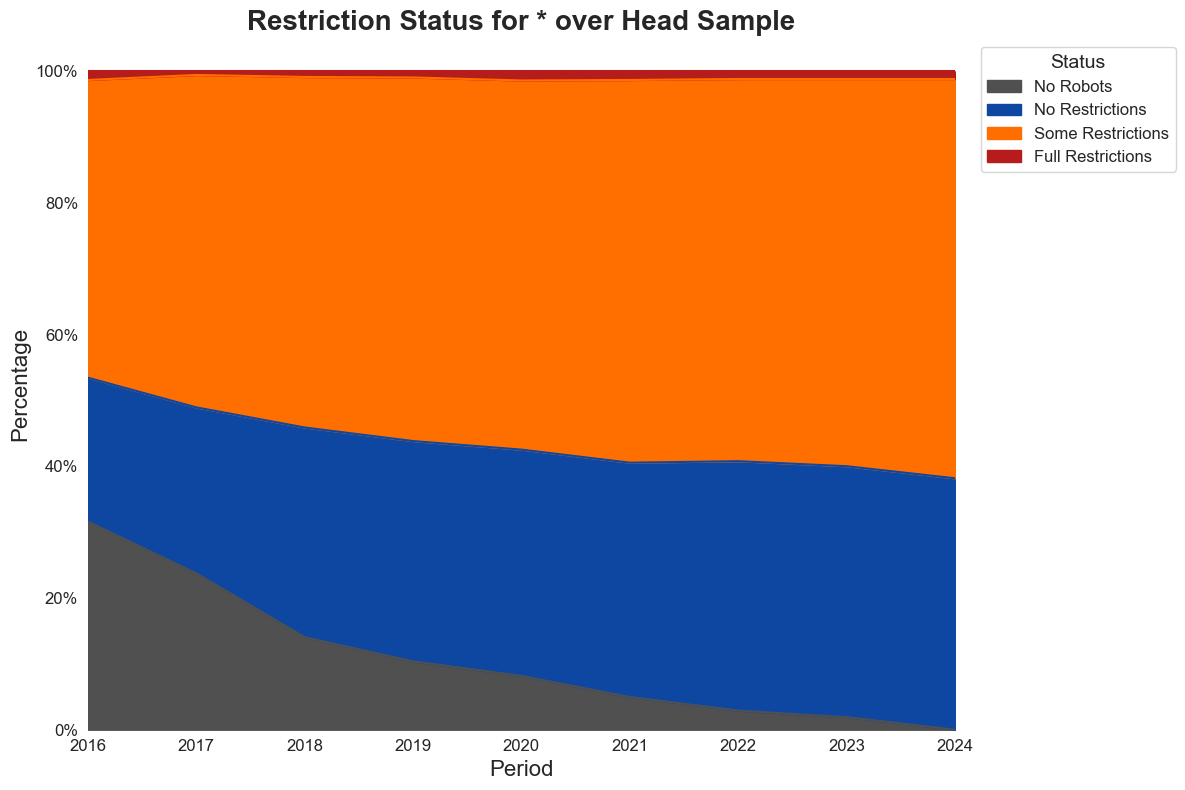

<Figure size 640x480 with 0 Axes>

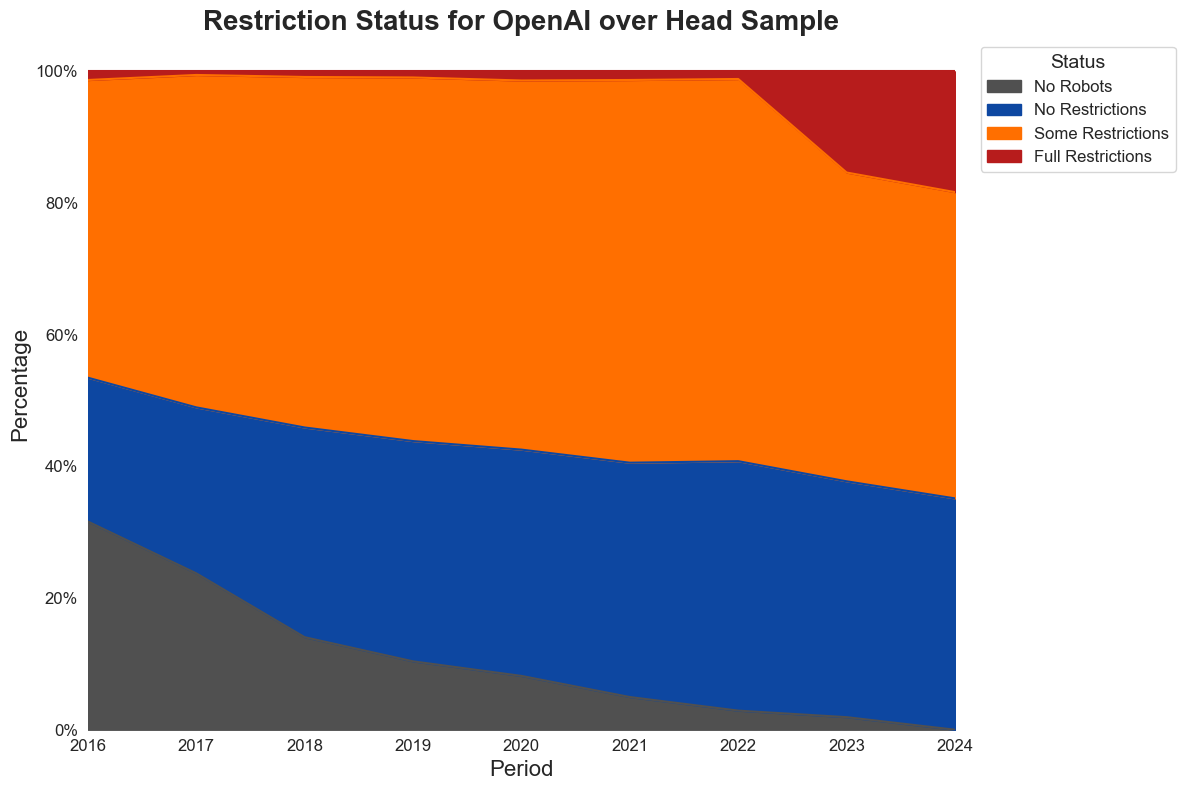

<Figure size 640x480 with 0 Axes>

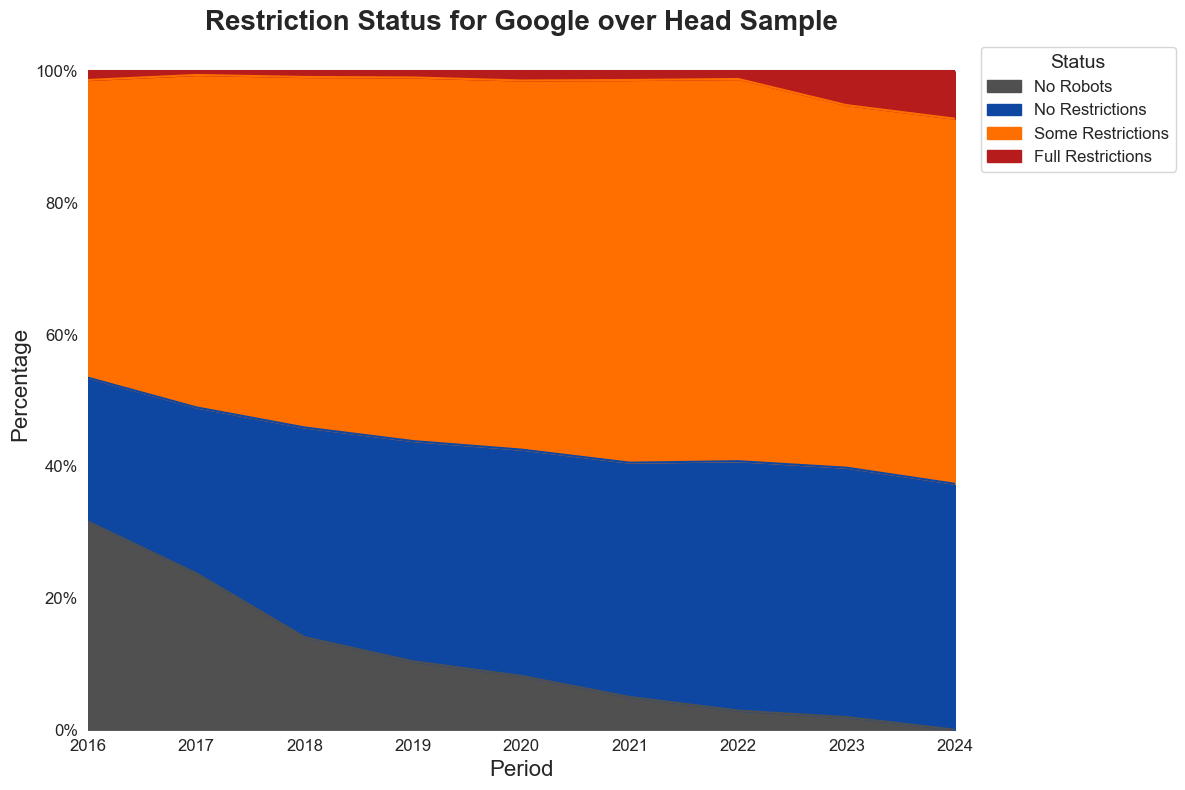

<Figure size 640x480 with 0 Axes>

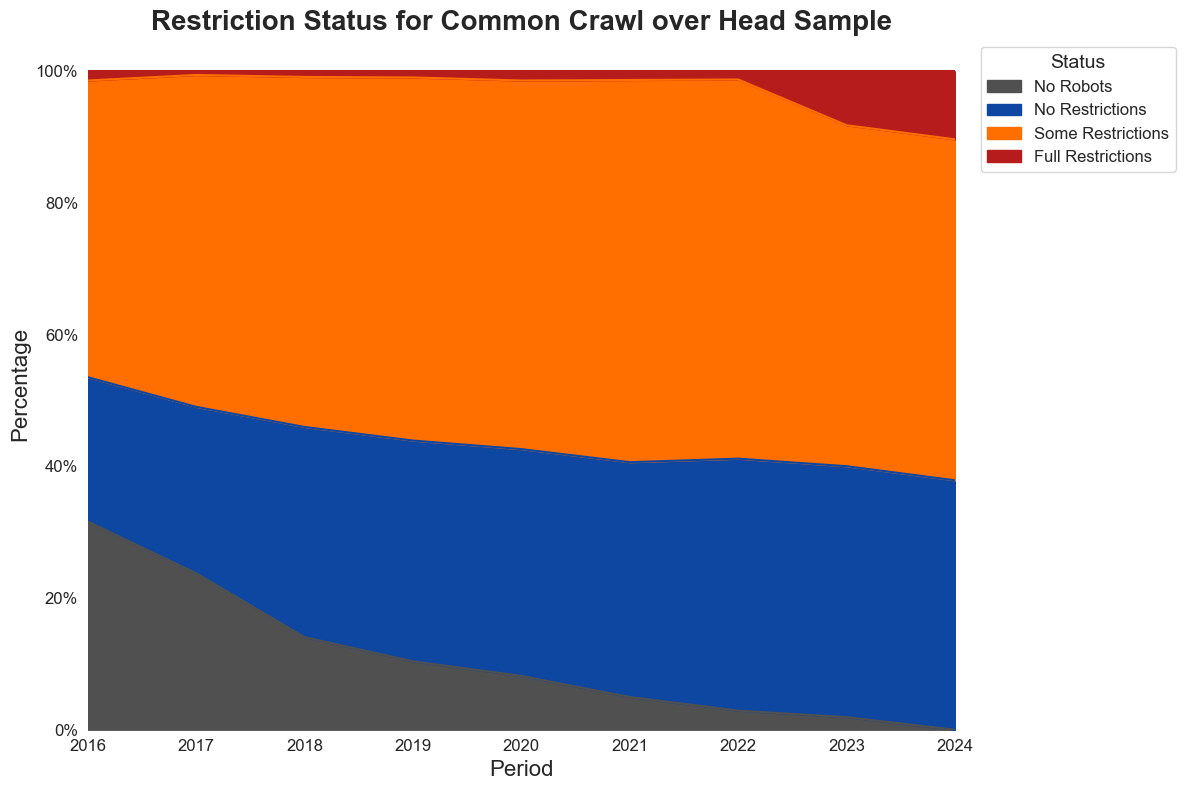

<Figure size 640x480 with 0 Axes>

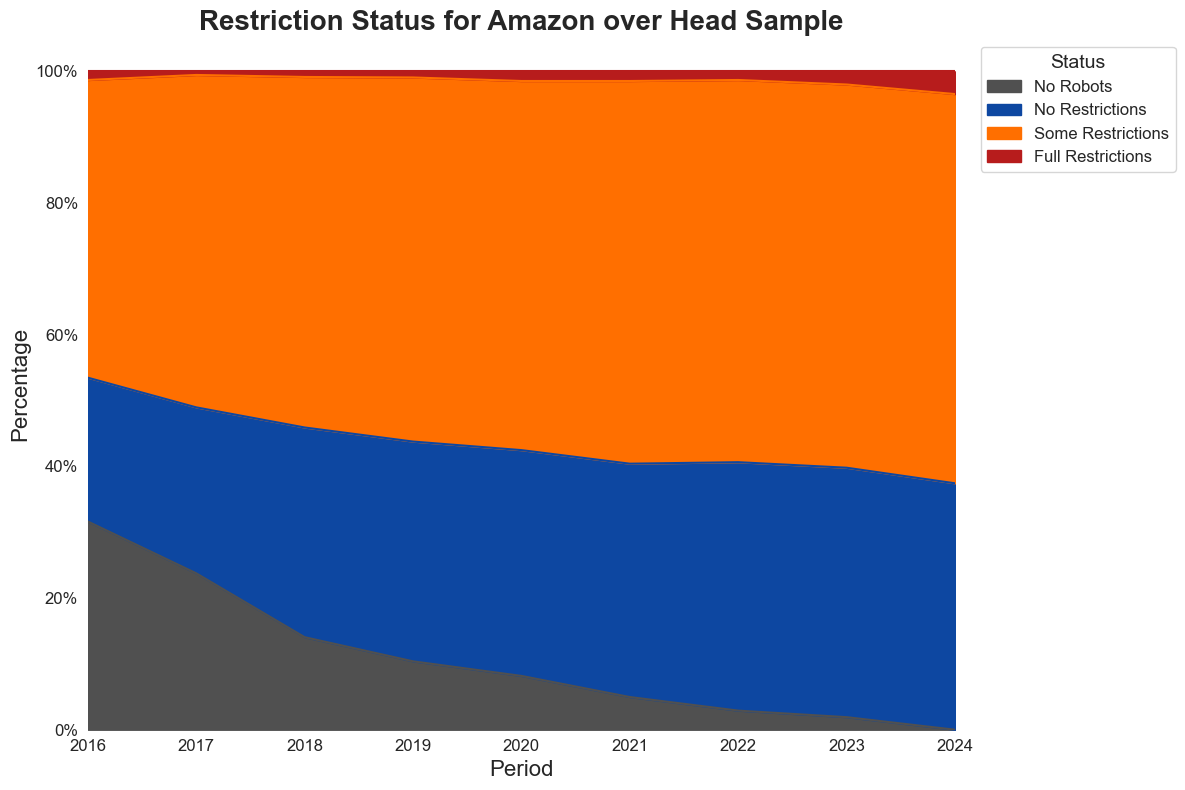

<Figure size 640x480 with 0 Axes>

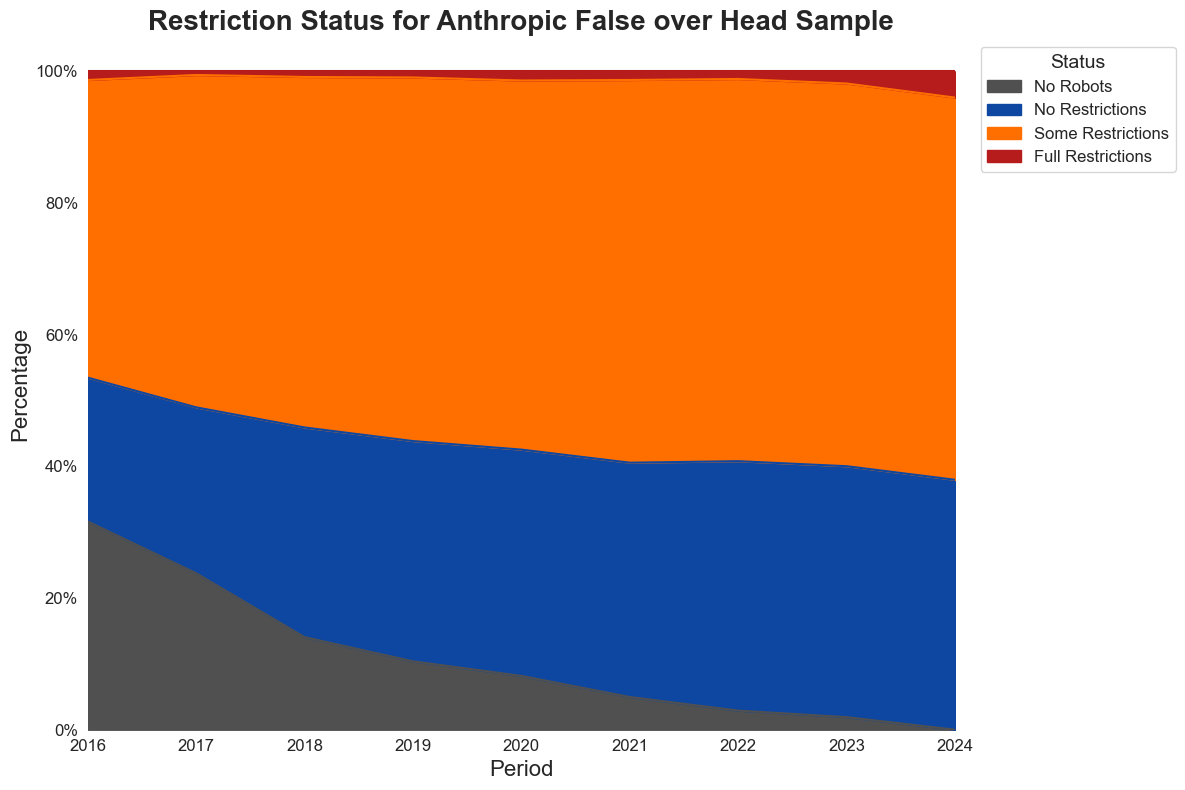

<Figure size 640x480 with 0 Axes>

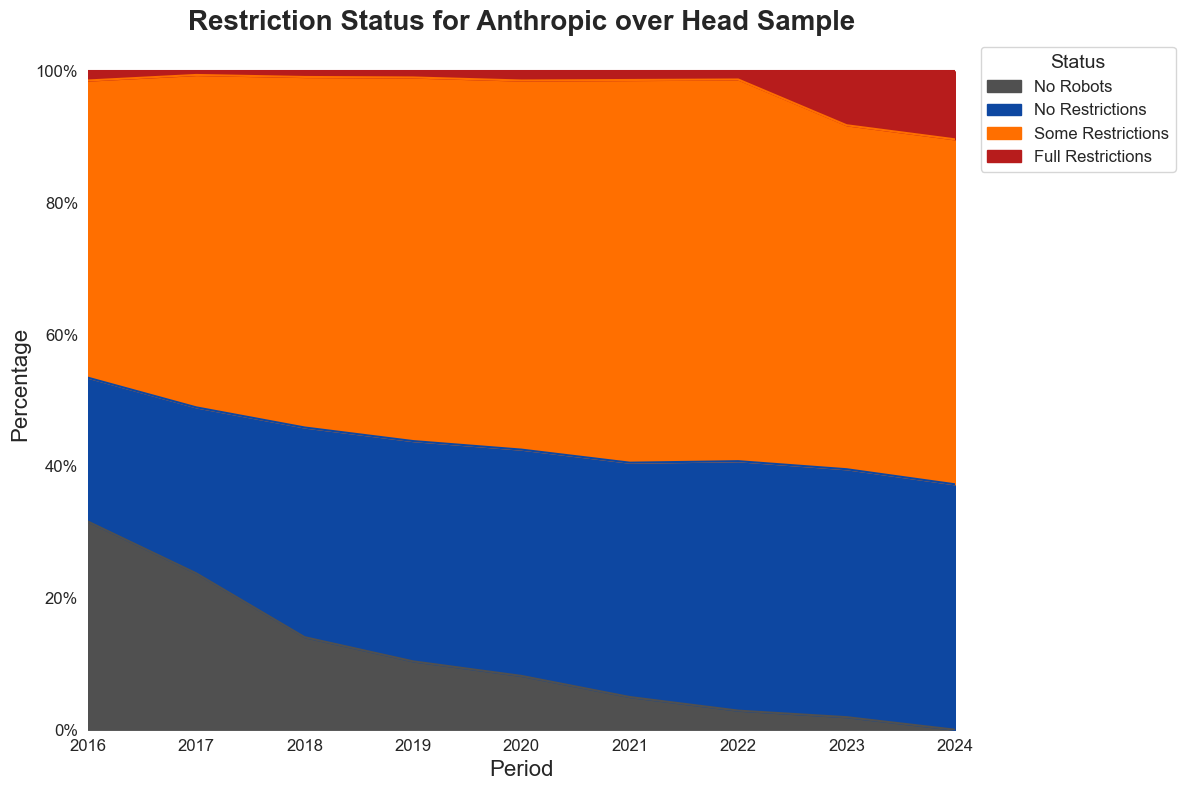

<Figure size 640x480 with 0 Axes>

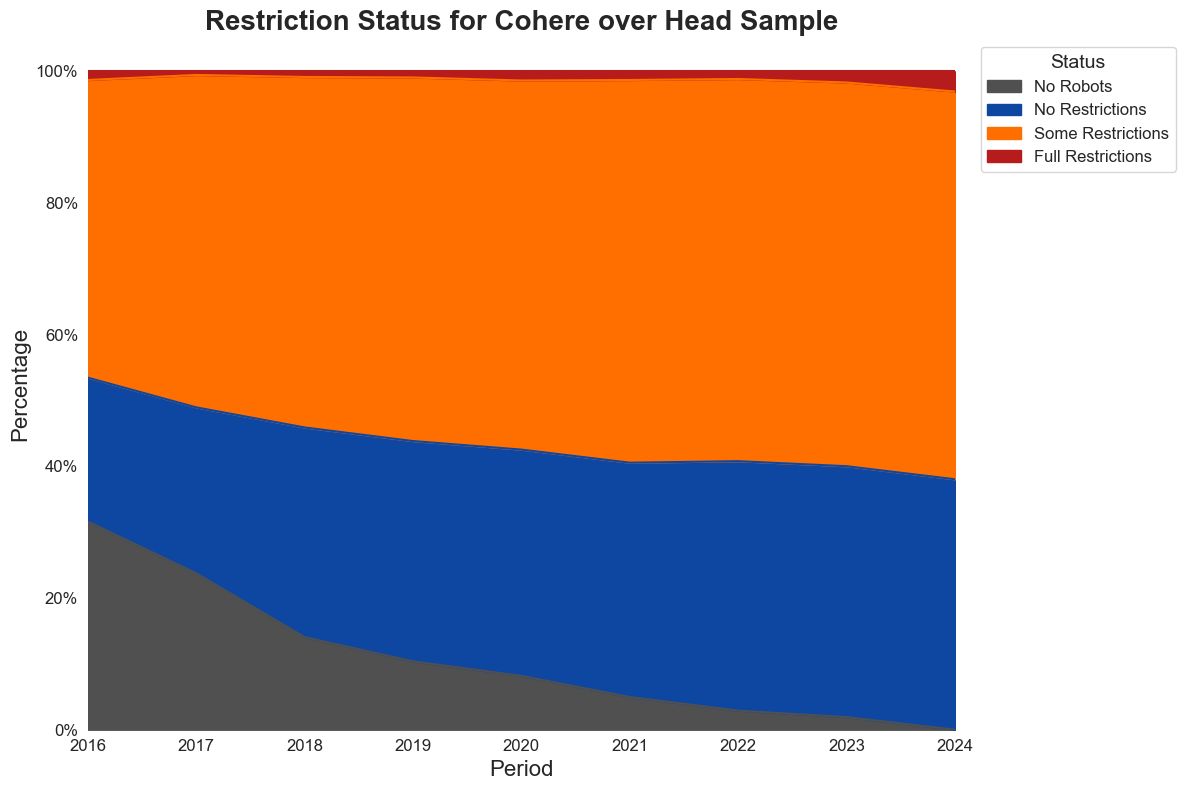

<Figure size 640x480 with 0 Axes>

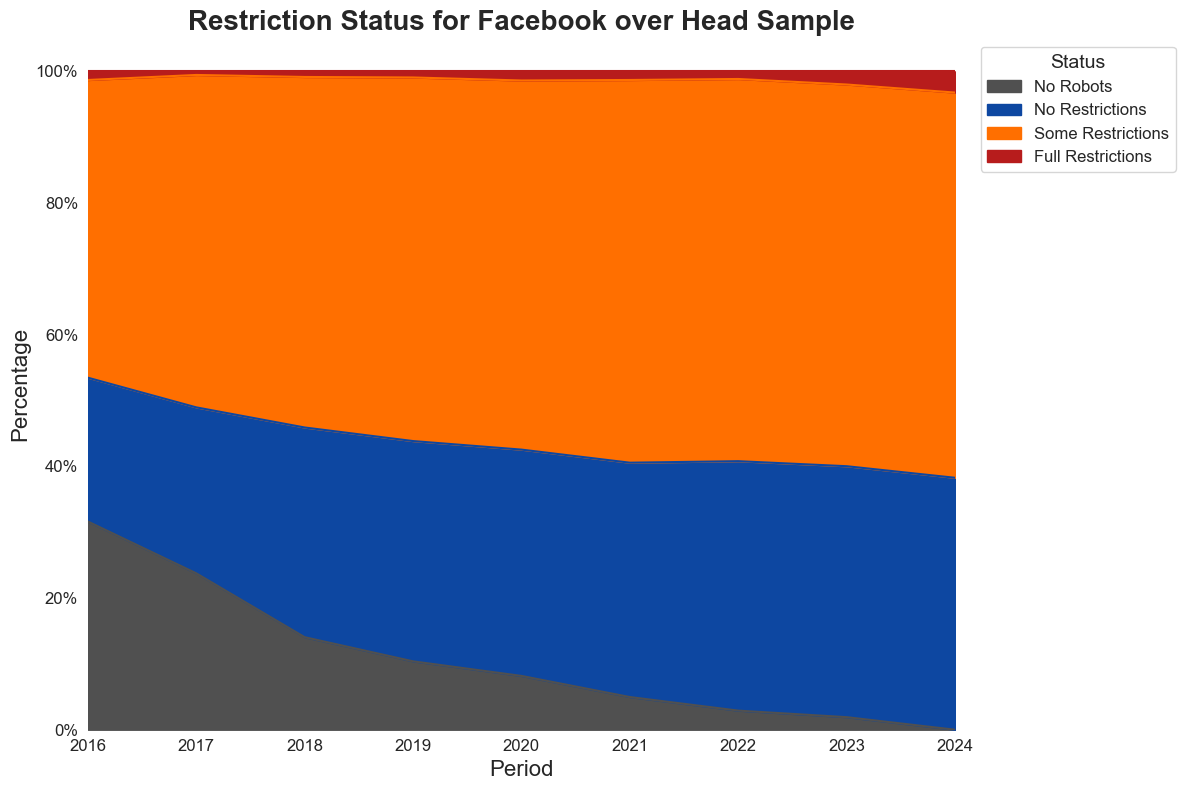

<Figure size 640x480 with 0 Axes>

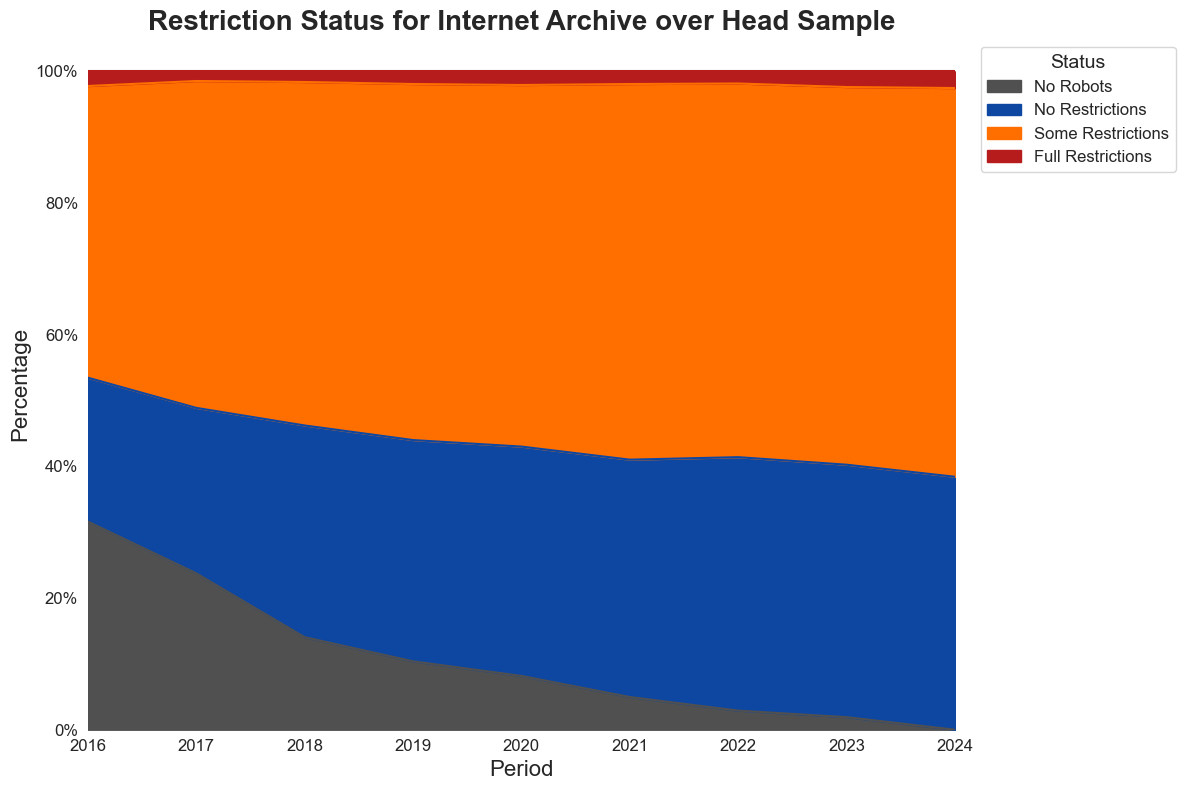

<Figure size 640x480 with 0 Axes>

In [2]:

# {Period --> Agent --> Status --> set(URLs)}
robots_filled_status_head_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_head, 
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="Y",
    website_start_dates=website_start_dates,  # Pass the website start dates
)
robots_filled_status_rand_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_rand, 
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="Y",
    website_start_dates=website_start_dates,  # Pass the website start dates
)


# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_head_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_head_summary,
    url_to_counts=c4_url_to_counts,
)
# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_rand_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_rand_summary,
    url_to_counts=c4_url_to_counts,
)


# Loop through the agent groups and plot the data
for group in agent_groups_to_track:
    plot_robots_time_map(robots_temporal_head_summary, group, val_key="count")

## Temporal Timeline & SARIMA predictions

note: SARIMA predictions just added for fun, can be removed. Used test set for SARIMA to validate results, then ran on full data.

/var/folders/25/9yr0mc3d0974r1jyhtw4rsg40000gn/T/ipykernel_50578/3022473629.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Changes'] = df['Changes'].fillna(method='ffill')


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-48.359, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-29.318, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-70.636, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-38.781, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-76.842, Time=0.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-61.257, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-75.823, Time=0.92 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-79.893, Time=1.26 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-74.432, Time=1.11 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-81.715, T

/var/folders/25/9yr0mc3d0974r1jyhtw4rsg40000gn/T/ipykernel_50578/3022473629.py:103: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df['Month'].iloc[-1], periods=n_periods + 1, freq='M')[1:]


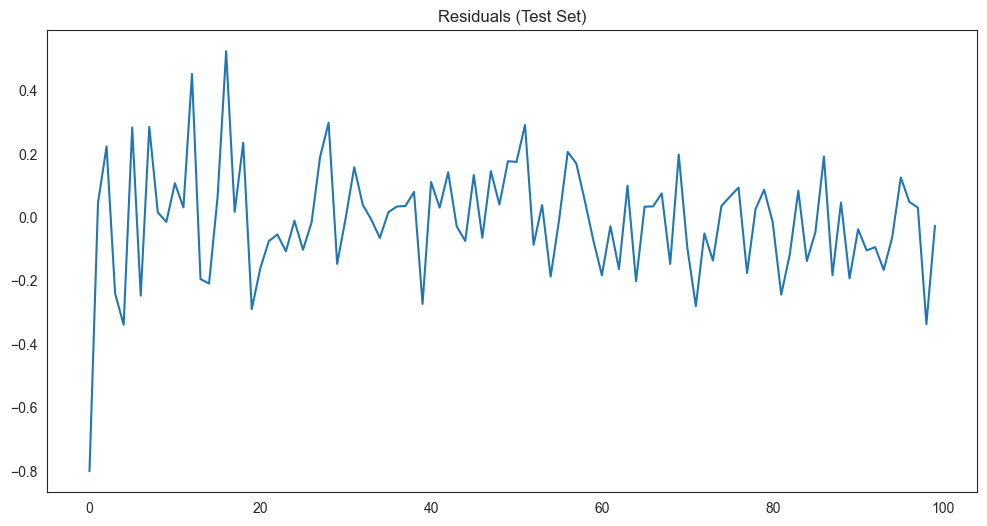

(100, 1)


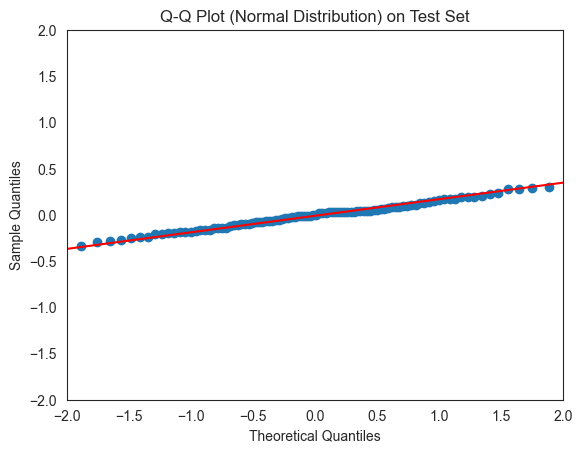

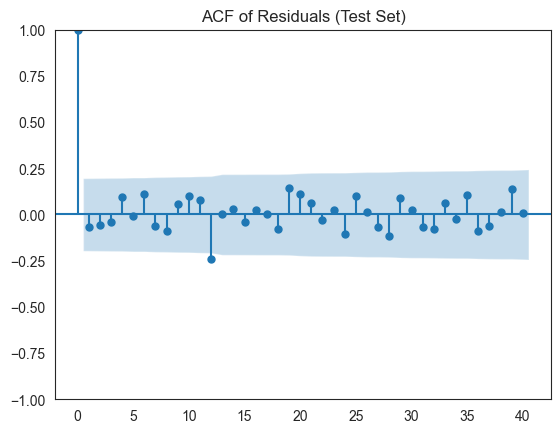

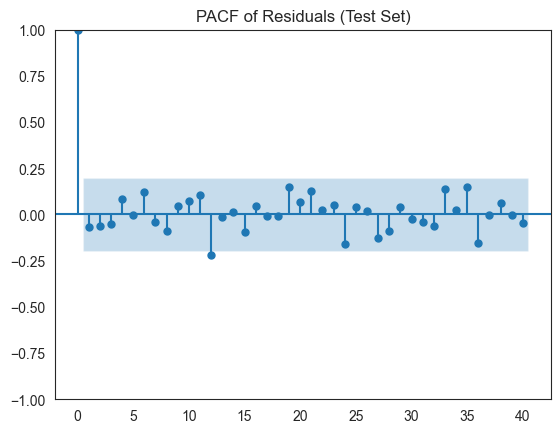

In [3]:
# TODO: use json files instead of directories
stats_path = 'wayback_extraction/stats_tos'
snapshots_path = 'wayback_extraction/snapshots_tos'

monthly_changes = {}

for filename in os.listdir(stats_path):
    if filename.endswith('.json'):
        file_path = os.path.join(stats_path, filename)
        
        # check for corresponding snapshots folder
        snapshot_folder = os.path.join(snapshots_path, filename.replace('.json', ''))
        if not os.path.isdir(snapshot_folder):
            with open(file_path, 'r') as file:
                data = json.load(file)
                change_counts = data.get('change_counts', {})
                
                # aggregate changes starting from the first snapshot month
                for month, changes in change_counts.items():
                    if month in monthly_changes:
                        monthly_changes[month] += changes
                    else:
                        monthly_changes[month] = changes
        else:
            with open(file_path, 'r') as file:
                data = json.load(file)
                change_counts = data.get('change_counts', {})
                
                # find first snapshot file in snapshot folder
                first_snapshot_month = None
                for snapshot in sorted(os.listdir(snapshots_path)):
                    try:
                        snapshot_month = snapshot[:7]
                        first_snapshot_month = snapshot_month
                        break
                    except IndexError:
                        continue
                
                # if no snapshot is found, skip this JSON file
                if first_snapshot_month is None:
                    continue
                
                # aggregate changes starting from the first snapshot month
                for month, changes in change_counts.items():
                    if month >= first_snapshot_month:
                        if month in monthly_changes:
                            monthly_changes[month] += changes
                        else:
                            monthly_changes[month] = changes
                        
# Convert the aggregated data to a Pandas DataFrame
df = pd.DataFrame(list(monthly_changes.items()), columns=['Month', 'Changes'])
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values('Month')

# Replace infinite values with NaN (occurs when dividing by zero)
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Handle missing values if necessary
df['Changes'] = df['Changes'].fillna(method='ffill')

# Box-Cox transformation to stabilize variance
df['BoxCox_Changes'], lam = boxcox(df['Changes'] + 1)  # Adding 1 to avoid log(0)

# Robust scaling
scaler = RobustScaler()
df['Scaled_Changes'] = scaler.fit_transform(df[['BoxCox_Changes']])

# Create exogenous variables for special events
special_events = {
    'California Privacy Rights Act (CPRA)': '2018-01-01',
    'CommonCrawl Release (April 2019)': '2019-04-01',
    'COVID-19 Pandemic': '2020-03-01',
    'Release of ChatGPT': '2022-12-01',
    'Release of GPT-4': '2023-03-08',
    'EU AI Regulations': '2024-04-01'
}
df['Special_Event'] = 0
for event, date in special_events.items():
    df.loc[df['Month'] == pd.to_datetime(date), 'Special_Event'] = 1

# Fit SARIMA model on the entire dataset with exogenous variables
sarimax_model_all = auto_arima(
    df['Scaled_Changes'].dropna(),
    exogenous=df[['Special_Event']],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True, m=12,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Print the model summary for the model trained on all data
print(sarimax_model_all.summary())

# Forecast future values (e.g., 12 months ahead)
n_periods = 12
future_dates = pd.date_range(start=df['Month'].iloc[-1], periods=n_periods + 1, freq='M')[1:]
exog_future = np.zeros((n_periods, 1))  # Assuming no special events in the future predictions
future_predictions, future_conf_int = sarimax_model_all.predict(n_periods=n_periods, exogenous=exog_future, return_conf_int=True)

# Convert Series to NumPy array before reshaping
future_predictions = future_predictions.values.reshape(-1, 1)
future_conf_int = future_conf_int.reshape(-1, 2)

# Inverse scaling and Box-Cox transformation for future predictions
future_predictions = scaler.inverse_transform(future_predictions).flatten()
future_predictions = (future_predictions * lam + 1) ** (1 / lam) - 1

# Inverse scaling and Box-Cox transformation for confidence intervals
future_conf_int = scaler.inverse_transform(future_conf_int)
future_conf_int = (future_conf_int * lam + 1) ** (1 / lam) - 1

# Create DataFrame for future predictions
future_df = pd.DataFrame({
    'Month': future_dates,
    'SARIMA_Predicted': future_predictions,
    'Conf_Lower': future_conf_int[:, 0],
    'Conf_Upper': future_conf_int[:, 1]
})

# Combine data for plotting
df_combined = pd.concat([df, future_df], ignore_index=True)

residuals = pd.DataFrame(sarimax_model_all.resid())

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals (Test Set)')
plt.show()

print(residuals.shape)

# Q-Q plot with normal distribution (default)
fig, ax = plt.subplots()
sm.qqplot(residuals.values.ravel(), line='s', ax=ax)
ax.set_title('Q-Q Plot (Normal Distribution) on Test Set')
ax.set_xlim(-2, 2)  # Adjust the x-axis range
ax.set_ylim(-2, 2)  # Adjust the y-axis range
plt.show()

# ACF and PACF plots of residuals
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals (Test Set)')
plt.show()

plot_pacf(residuals, lags=40)
plt.title('PACF of Residuals (Test Set)')
plt.show()

# Create an interactive plot with Plotly
fig = go.Figure()

# Add SARIMA predictions and confidence intervals for future
fig.add_trace(go.Scatter(
    x=future_df['Month'], y=future_df['SARIMA_Predicted'], mode='lines',
    name='SARIMA Predictions', line=dict(color='#4d94ff', width=3, dash='dot')
))
fig.add_trace(go.Scatter(
    x=future_df['Month'], y=future_df['Conf_Lower'], mode='lines',
    line=dict(width=0), showlegend=False
))
fig.add_trace(go.Scatter(
    x=future_df['Month'], y=future_df['Conf_Upper'], mode='lines',
    line=dict(width=0), fill='tonexty', fillcolor='rgba(77, 148, 255, 0.2)',
    name='Confidence Interval'
))

# Add actual data points
fig.add_trace(go.Scatter(
    x=df['Month'], y=df['Changes'], mode='lines+markers',
    name='Data', marker=dict(color='#ff6347', size=8)
))

# Add annotations for important events with adjusted positions
annotation_dates = [
    ('2018-01-01', "California Privacy Rights Act (CPRA)"),
    ('2019-04-01', "CommonCrawl Release (April 2019)"),
    ('2020-03-01', "COVID-19 Pandemic"),
    ('2022-12-01', "Release of ChatGPT"),
    ('2023-03-08', "Release of GPT-4"),
    ('2024-04-01', "EU AI Regulations"),
]

# Adjust annotation positions
annotation_positions = {
    '2018-01-01': {'y_shift': 50, 'x_shift': 20},
    '2019-04-01': {'y_shift': -100, 'x_shift': -20},
    '2020-03-01': {'y_shift': -110, 'x_shift': -40},
    '2022-12-01': {'y_shift': 75, 'x_shift': -20},
    '2023-03-08': {'y_shift': -50, 'x_shift': -40},
    '2024-04-01': {'y_shift': 75, 'x_shift': 20},
}

for date_str, text in annotation_dates:
    date = pd.to_datetime(date_str)
    y_value = df_combined.loc[df_combined['Month'] == date, 'Changes'].values
    if len(y_value) == 0:
        # If no data for the exact date, find the closest previous date with data
        closest_date_idx = (df_combined['Month'] - date).abs().argsort()[0]
        closest_date = df_combined.iloc[closest_date_idx]['Month']
        y_value = df_combined.iloc[closest_date_idx]['Changes']
    else:
        y_value = y_value[0]
    
    shifts = annotation_positions.get(date_str, {'y_shift': -40, 'x_shift': 0})
    
    fig.add_annotation(
        x=date, y=y_value,
        text=text, showarrow=True, arrowhead=1,
        ax=shifts['x_shift'], ay=shifts['y_shift'],
        font=dict(color='#333333', size=14),
        align='center',
        bordercolor='#c7c7c7',
        borderwidth=2,
        borderpad=4,
        bgcolor='#ffffff',
        opacity=0.8
    )

# Update layout for better aesthetics and readability
fig.update_layout(
    title=dict(text="TOS Changes Timeline", font=dict(size=24, color='#333333')),
    xaxis=dict(title="Month", tickformat='%b %Y', tickangle=45, tickfont=dict(size=14), title_font=dict(size=16)),
    yaxis=dict(title="Number of Changes", tickfont=dict(size=14), title_font=dict(size=16)),
    legend=dict(
        x=0.01, y=0.99,
        bgcolor='rgba(255, 255, 255, 0.8)',
        font=dict(size=14),
        title=dict(text='<b>Legend</b>', font=dict(size=16)),
        title_font_color='#333333'
    ),
    template="plotly_white",
    plot_bgcolor='#f0f0f0',
    width=1200,
    height=600,
    font_family="Times",
    font_color="#333333",
    title_font_family="Times",
    title_font_color="#333333",
    legend_title_font_color="#333333",
    title_x=0.5,
    margin=dict(l=40, r=40, t=80, b=80),
)

# Add horizontal gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e0e0e0')
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e0e0e0')

# Show the plot
fig.show()
